# Sequence Models

We try predicting a sinusoid (with added noise) using a Multi-Layer Perceptron.

https://d2l.ai/chapter_recurrent-neural-networks/sequence.html

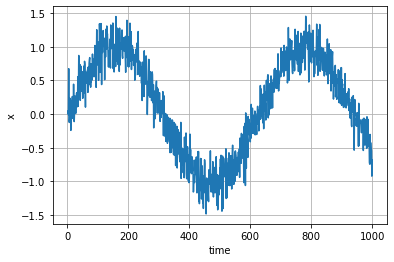

In [14]:
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt

T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

plt.plot(time, x)
plt.xlabel('time')
plt.ylabel('x')
plt.grid()

In [15]:
from torch.utils.data import TensorDataset, DataLoader

tau = 16
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training


def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator """
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

train_iter = load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [16]:
 # Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(tau, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

def get_net2():
    net = nn.Sequential(nn.Linear(tau, 10),
                        nn.Linear(10, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Note: `MSELoss` computes squared error without the 1/2 factor
loss = nn.MSELoss(reduction='none')

In [17]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset (data_iter).

    Defined in :numref:`sec_utils`"""
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = reshape(y, out.shape)
        l = loss(out, y)
        metric.add(reduce_sum(l), size(l))
    return metric[0] / metric[1]



def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            # Compute Loss
            pred = net(X)
            l = loss(pred, y)
            # Backpropagation
            trainer.zero_grad()
            l.sum().backward()
            trainer.step()
            
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.079714
epoch 2, loss: 0.062971
epoch 3, loss: 0.059389
epoch 4, loss: 0.058067
epoch 5, loss: 0.058501


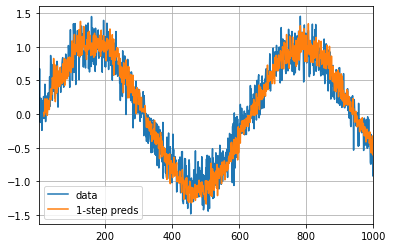

In [18]:
onestep_preds = net(features)
plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:],  onestep_preds.detach().numpy(), label='1-step preds')
plt.legend()
plt.xlim([1, 1000])
plt.grid()

The one-step-ahead predictions look nice, just as we expected. Even beyond 604 (n_train + tau) observations the predictions still look trustworthy. However, there is just one little problem to this: if we observe sequence data only until time step 604, we cannot hope to receive the inputs for all the future one-step-ahead predictions. Instead, we need to work our way forward one step at a time:

Generally, for an observed sequence up to , its predicted output at time step  is called the -step-ahead prediction. Since we have observed up to , its -step-ahead prediction is . In other words, we will have to use our own predictions to make multistep-ahead predictions. Let us see how well this goes.

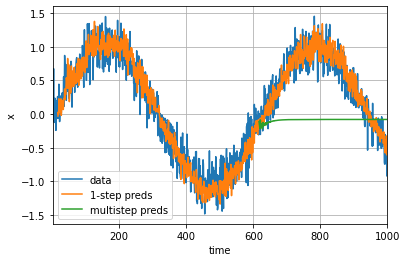

In [19]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:],  onestep_preds.detach().numpy(), label='1-step preds')
plt.plot(time[n_train + tau:],  multistep_preds[n_train + tau:].detach().numpy(), label='multistep preds')
plt.legend()
plt.ylabel('x')
plt.xlabel('time')
plt.xlim([1, 1000])
plt.grid()

(5.0, 1000.0)

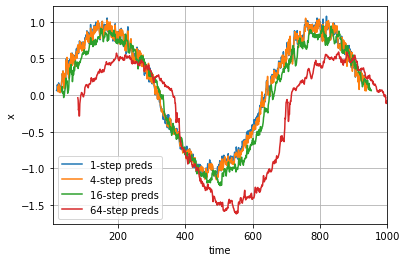

In [7]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
for i in steps:
    plt.plot(time[tau + i - 1: T - max_steps + i], 
                features[:, (tau + i - 1)].detach().numpy(), 
                label = f'{i}-step preds')
plt.ylabel('x')
plt.xlabel('time')
plt.legend()
plt.grid()

plt.xlim([5, 1000])

Using another neural network with one more layer.

In [10]:
net2 = get_net2()
train(net2, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.055397
epoch 2, loss: 0.054894
epoch 3, loss: 0.048168
epoch 4, loss: 0.047194
epoch 5, loss: 0.045042


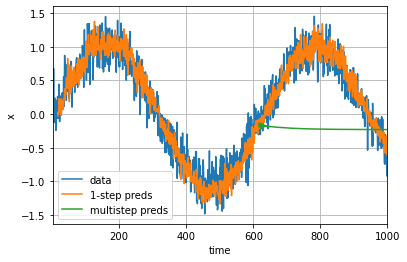

In [22]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net2(
        multistep_preds[i - tau:i].reshape((1, -1)))

plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:],  onestep_preds.detach().numpy(), label='1-step preds')
plt.plot(time[n_train + tau:],  multistep_preds[n_train + tau:].detach().numpy(), label='multistep preds')
plt.legend()
plt.ylabel('x')
plt.xlabel('time')
plt.xlim([1, 1000])
plt.grid()

(5.0, 1000.0)

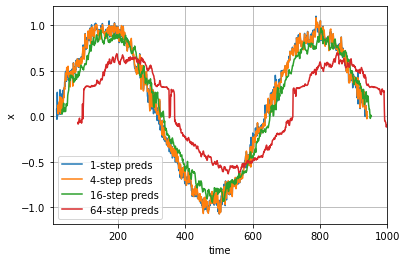

In [20]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net2(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
for i in steps:
    plt.plot(time[tau + i - 1: T - max_steps + i], 
                features[:, (tau + i - 1)].detach().numpy(), 
                label = f'{i}-step preds')
plt.ylabel('x')
plt.xlabel('time')
plt.legend()
plt.grid()

plt.xlim([5, 1000])

Question: why is evaluate_loss written like this?


## Exercises
1. Improve the model in the experiment of this section.

   1. Incorporate more than the past 4 observations? How many do you really need?

   2. How many past observations would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.

      **A**: Suppose you knew that your model followed a sinusoid, that is $A \sin(B t + C) + D$. We see that it can be completely described by 4 constants. Which means that we need 4 datapoints as a minimum. 

   3. Can you incorporate older observations while keeping the total number of features constant? Does this improve accuracy? Why?
      **A**: The more older observations the model has, the more the accuracy improves. However this nature of the neural network forbids it.

   4. Change the neural network architecture and evaluate the performance.

2. An investor wants to find a good security to buy. He looks at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?

   **A**: Past performance does not necessarily predict future performance. The model would only replicate past trends and offer no insight into future opportunities.

3. Does causality also apply to text? To which extent?

   **A**: To a certain extent, as certain parts of speech (noun, verbs, prepositions) almost certainly occur after other words. Also some words tend to appear in conjunction.

4. Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.
   **A**: Perhaps something with varying frequency?  Or arguably anything more complex.